In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings

warnings.filterwarnings('ignore')

print("--- ETAPA 1: INCARCARE SI INDEXARE ---")

filename = 'CLEAN_House1.csv'

# 1. Incarcare directa
print(f"[INFO] Se incarca '{filename}'...")
df = pd.read_csv(filename)

# 2. Setare Index Timp (Direct pe coloana 'Time')
print("[INFO] Se proceseaza coloana 'Time'...")
df['dt'] = pd.to_datetime(df['Time'])
df.set_index('dt', inplace=True)

# 3. Selectie Coloane
# Pastram doar Aggregate
df = df[['Aggregate']]

# Asigurare numeric
df['Aggregate'] = pd.to_numeric(df['Aggregate'], errors='coerce')

print(" -> Date incarcate. Exemplu:")
print(df.head(3))

--- ETAPA 1: INCARCARE SI INDEXARE ---
[INFO] Se incarca 'CLEAN_House1.csv'...
[INFO] Se proceseaza coloana 'Time'...
 -> Date incarcate. Exemplu:
                     Aggregate
dt                            
2013-10-09 13:06:17        523
2013-10-09 13:06:31        526
2013-10-09 13:06:46        540


In [8]:
print("\n--- ETAPA 2: PREPROCESARE SI FEATURES ---")

# 1. Resampling la 1 Minut
print("[INFO] Se face resampling la 1 minut...")
df_1min = df.resample('1min').mean().fillna(method='ffill')

# 2. Creare Trasaturi (Features)
print("[INFO] Se genereaza variabilele temporale (Sin/Cos)...")

# Extragere ora si zi
df_1min['Hour'] = df_1min.index.hour
df_1min['DayOfWeek'] = df_1min.index.dayofweek

# Codare Ciclica (Sin/Cos) - Esentiala pentru AI
df_1min['Hour_Sin'] = np.sin(2 * np.pi * df_1min['Hour'] / 24.0)
df_1min['Hour_Cos'] = np.cos(2 * np.pi * df_1min['Hour'] / 24.0)

# Weekend (0 sau 1)
df_1min['IsWeekend'] = df_1min['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Normalizare simpla zi saptamana
df_1min['DayOfWeek_Scaled'] = df_1min['DayOfWeek'] / 6.0

print(f" -> Dimensiune finala dataset: {df_1min.shape}")


--- ETAPA 2: PREPROCESARE SI FEATURES ---
[INFO] Se face resampling la 1 minut...
[INFO] Se genereaza variabilele temporale (Sin/Cos)...
 -> Dimensiune finala dataset: (920091, 7)



--- ETAPA 3: ANALIZA SILHOUETTE (OPTIMIZARE K) ---
[INFO] Analizam structura pe un esantion de 50000 puncte...
 -> k=2: Silhouette Score = 0.8646
 -> k=3: Silhouette Score = 0.8164
 -> k=4: Silhouette Score = 0.8212
 -> k=5: Silhouette Score = 0.7204


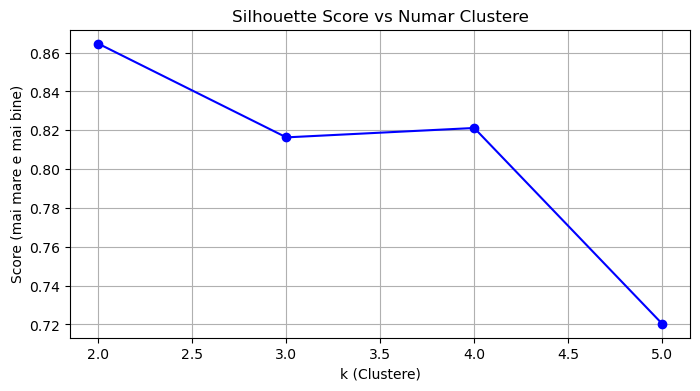

[CONCLUZIE] Cel mai bun k este: 2


In [9]:
print("\n--- ETAPA 3: ANALIZA SILHOUETTE (OPTIMIZARE K) ---")

# Folosim un esantion de 50.000 puncte pentru viteza
sample_size = 50000
print(f"[INFO] Analizam structura pe un esantion de {sample_size} puncte...")

data_sample = df_1min[['Aggregate']].sample(n=sample_size, random_state=42).values

range_n_clusters = [2, 3, 4, 5]
scores = []

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data_sample)
    
    score = silhouette_score(data_sample, labels)
    scores.append(score)
    print(f" -> k={k}: Silhouette Score = {score:.4f}")

# Vizualizare
plt.figure(figsize=(8, 4))
plt.plot(range_n_clusters, scores, 'bo-')
plt.title('Silhouette Score vs Numar Clustere')
plt.xlabel('k (Clustere)')
plt.ylabel('Score (mai mare e mai bine)')
plt.grid(True)
plt.show()

best_k = range_n_clusters[np.argmax(scores)]
print(f"[CONCLUZIE] Cel mai bun k este: {best_k}")


--- ETAPA 4: APLICARE CLUSTERE (k=2) ---
[REZULTAT] Centre: Low=427.15W, High=3490.62W
[REZULTAT] Prag separare: 1958.88 W


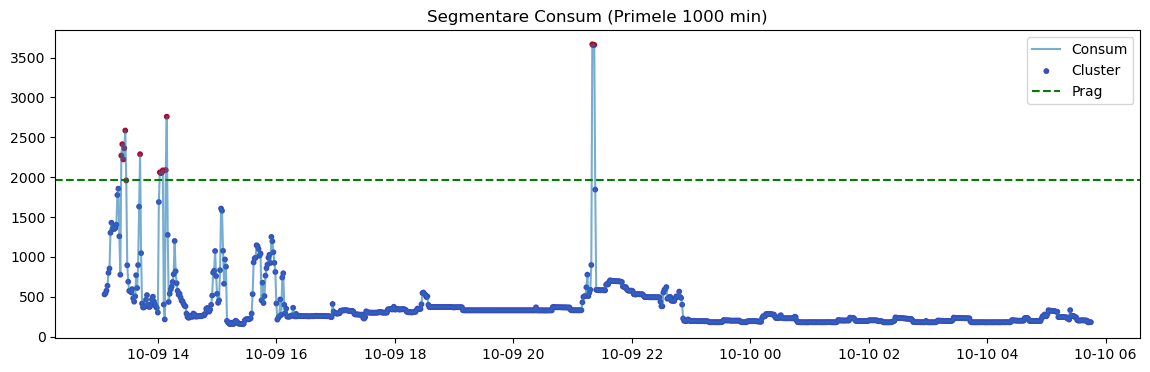

In [10]:
print(f"\n--- ETAPA 4: APLICARE CLUSTERE (k={best_k}) ---")


# 1. Antrenare pe tot setul
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df_1min['Cluster'] = kmeans_final.fit_predict(df_1min[['Aggregate']].values)

# 2. Ordonare Clustere (0 = Low, 1 = High)
centers = kmeans_final.cluster_centers_.flatten()
sorted_idx = np.argsort(centers) # Indicii sortati crescator

# Daca clusterul 0 are valoarea mare, inversam etichetele
if centers[0] > centers[1]:
    print("[INFO] Se inverseaza etichetele (0 -> High devine 1 -> High)...")
    df_1min['Cluster'] = 1 - df_1min['Cluster']
    centers = centers[::-1] # Inversam si vectorul de centre pentru printare

# 3. Calcul Prag
threshold = (centers[0] + centers[1]) / 2

print(f"[REZULTAT] Centre: Low={centers[0]:.2f}W, High={centers[1]:.2f}W")
print(f"[REZULTAT] Prag separare: {threshold:.2f} W")

# Grafic  confirmare
plt.figure(figsize=(14, 4))
subset = df_1min.iloc[:1000]
plt.plot(subset.index, subset['Aggregate'], label='Consum', alpha=0.6)
plt.scatter(subset.index, subset['Aggregate'], c=subset['Cluster'], cmap='coolwarm', s=10, label='Cluster')
plt.axhline(y=threshold, color='green', linestyle='--', label='Prag')
plt.legend()
plt.title('Segmentare Consum (Primele 1000 min)')
plt.show()

In [11]:
print("\n--- ETAPA 5: PREPARARE DATE SECVENȚIALE (DEEP LEARNING) ---")
from sklearn.preprocessing import RobustScaler
# Scalare (MinMax 0-1)
scaler = RobustScaler()
df_1min['Aggregate_Scaled'] = scaler.fit_transform(df_1min[['Aggregate']])

# Lista features 
features_cols = ['Aggregate_Scaled', 'Hour_Sin', 'Hour_Cos', 'DayOfWeek_Scaled', 'IsWeekend', 'Cluster']
dataset = df_1min[features_cols].values

# Functie Sliding Window
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])     # Input: Istoric
        y.append(data[i, 0])                 # Target: Consum (col 0)
    return np.array(X), np.array(y)

WINDOW_SIZE = 60
TRAIN_SPLIT = 0.8

# 1. Split data
train_len = int(len(dataset) * TRAIN_SPLIT)
train_data = dataset[:train_len]
test_data_values = dataset[train_len:] 

# 2. Generare Secvente 
X_train, y_train = create_sequences(train_data, WINDOW_SIZE)

# Test input cu overlap
test_inputs = np.concatenate((train_data[-WINDOW_SIZE:], test_data_values))
X_test, y_test = create_sequences(test_inputs, WINDOW_SIZE)

print(f" -> X_train: {X_train.shape}")
print(f" -> X_test:  {X_test.shape}")

# Salvare rezultate
data_package = {
    'X_train': X_train,
    'y_train': y_train,
    'X_test': X_test,
    'y_test': y_test,
    'scaler': scaler,
    'kmeans': kmeans_final,
    
    'test_data': df_1min.iloc[train_len:],  
    'df_1min': df_1min,                     
    'train_size': train_len,                
    'WINDOW_SIZE': WINDOW_SIZE              
}

import pickle
with open('processed_data.pkl', 'wb') as f:
    pickle.dump(data_package, f)

print("[SUCCESS] Fisier 'processed_data.pkl' salvat. Poti rula 02_Model_Training.ipynb pentru antrenare.")


--- ETAPA 5: PREPARARE DATE SECVENȚIALE (DEEP LEARNING) ---
 -> X_train: (736012, 60, 6)
 -> X_test:  (184019, 60, 6)
[SUCCESS] Fisier 'processed_data.pkl' salvat. Poti rula 02_Model_Training.ipynb pentru antrenare.


In [12]:
# Vezi primele 10 rânduri 
print("--- PRIMELE 10 RÂNDURI (HEAD) ---")
print(df_1min.head(10))

# Vezi ultimele 10 rânduri (Cele mai recente date)
print("\n--- ULTIMELE 10 RÂNDURI (TAIL) ---")
print(df_1min.tail(10))



--- PRIMELE 10 RÂNDURI (HEAD) ---
                       Aggregate  Hour  DayOfWeek  Hour_Sin  Hour_Cos  \
dt                                                                      
2013-10-09 13:06:00   529.666667    13          2 -0.258819 -0.965926   
2013-10-09 13:07:00   543.875000    13          2 -0.258819 -0.965926   
2013-10-09 13:08:00   578.000000    13          2 -0.258819 -0.965926   
2013-10-09 13:09:00   638.300000    13          2 -0.258819 -0.965926   
2013-10-09 13:10:00   800.200000    13          2 -0.258819 -0.965926   
2013-10-09 13:11:00   854.200000    13          2 -0.258819 -0.965926   
2013-10-09 13:12:00  1302.300000    13          2 -0.258819 -0.965926   
2013-10-09 13:13:00  1429.000000    13          2 -0.258819 -0.965926   
2013-10-09 13:14:00  1346.700000    13          2 -0.258819 -0.965926   
2013-10-09 13:15:00  1370.200000    13          2 -0.258819 -0.965926   

                     IsWeekend  DayOfWeek_Scaled  Cluster  Aggregate_Scaled  
dt         